

#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Classifying Restaurant cuisine types based on user reviews`

#### Group:
- Dinis Fernandes #20221848
- Dinis Gaspar #20221869
- Inês Santos #20221916
- Luis Davila #20221949
- Sara Ferrer #20221947




#### <font color='#BFD72'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [0. Literature Review](#0-literature-review)
- [1. Imports](#1-imports)
- [2. The Data](#2-the-data)
- [3. Explanatory Data Analysis (EDA)](#3-explanatory-data-analysis-eda)
    - [3.1. General Analysis](#31-general-analysis)
    - [3.2. Wordclouds](#32-wordclouds)
- [4. Modelling](#4-modelling)
    - [4.1. TF-IDF](#41-tf-idf)
    - [4.2. Bag Of Words](#42-bag-of-words)
    - [4.3. Doc2Vec](#43-doc2vec)
    - [4.4 .BERT](#44-bert)
- [5. Final Model](#5-final-model)
- [6. References](#6-references)



# 0. Literature Review <a class="anchor" id='#0-literature-review'></a>

[1] T. Sharma, U. Upadhyay and G. Bagler, "Classification of Cuisines from Sequentially Structured Recipes," 2020 IEEE 36th International Conference on Data Engineering Workshops (ICDEW), Dallas, TX, USA, 2020, pp. 105-108, doi:10.1109/ICDEW49219.2020.00008.

# 1. Imports  
  
[Back to TOC](#toc)



In [31]:
import re
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skmultilearn.model_selection import IterativeStratification

from transformers import BertTokenizer

from wordcloud import WordCloud

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from utils import pipeline_v2

import nltk
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
sent_tokenizer=PunktSentenceTokenizer()

import os

pd.set_option('max_colwidth', 80)

import warnings
warnings.filterwarnings('ignore') 

# 2. The Data 
  
[Back to TOC](#toc)

<a class="anchor" id='#2-the-data'></a> 

Firstly, we'll start by importing and joining the reviews and restaurants datasets to obtain a dataset containing the review and the cuisine types for the corresponding restaurant. We'll only import relevant columns and will rename some of them for ease of use.

In [32]:
restaurants = pd.read_csv("data/105_restaurants.csv")
restaurants = restaurants.drop(columns=["Links","Cost","Collections","Timings"])
restaurants = restaurants.rename(columns={"Name":"Restaurant"})

restaurants.head()

,Restaurant,Cuisines
0,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian"
1,Paradise,"Biryani, North Indian, Chinese"
2,Flechazo,"Asian, Mediterranean, North Indian, Desserts"
3,Shah Ghouse Hotel & Restaurant,"Biryani, North Indian, Chinese, Seafood, Beverages"
4,Over The Moon Brew Company,"Asian, Continental, North Indian, Chinese, Mediterranean"


In [33]:
reviews = pd.read_csv("data/10k_reviews.csv").rename({'Review':'raw_review'}, axis=1)
reviews.drop(columns = ["Reviewer", "Metadata", "Time", "Pictures"], axis = 1, inplace=True)

reviews.head()

,Restaurant,raw_review,Rating
0,Beyond Flavours,"The ambience was good, food was quite good . had Saturday lunch , which was ...",5
1,Beyond Flavours,Ambience is too good for a pleasant evening. Service is very prompt. Food is...,5
2,Beyond Flavours,A must try.. great food great ambience. Thnx for the service by Pradeep and ...,5
3,Beyond Flavours,Soumen das and Arun was a great guy. Only because of their behavior and sinc...,5
4,Beyond Flavours,Food is good.we ordered Kodi drumsticks and basket mutton biryani. All are g...,5


In [34]:
reviews_copy = reviews.copy()
restaurants_copy = restaurants.copy()

In [35]:
restaurants_reviews = pd.merge(restaurants_copy,reviews_copy,on="Restaurant")
restaurants_reviews

,Restaurant,Cuisines,raw_review,Rating
0,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian","The ambience was good, food was quite good . had Saturday lunch , which was ...",5
1,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian",Ambience is too good for a pleasant evening. Service is very prompt. Food is...,5
2,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian",A must try.. great food great ambience. Thnx for the service by Pradeep and ...,5
3,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian",Soumen das and Arun was a great guy. Only because of their behavior and sinc...,5
4,Beyond Flavours,"Chinese, Continental, Kebab, European, South Indian, North Indian",Food is good.we ordered Kodi drumsticks and basket mutton biryani. All are g...,5
...,...,...,...,...
9995,Chinese Pavilion,"Chinese, Seafood",Madhumathi Mahajan Well to start with nice courteous servers and staff. Exce...,3
9996,Chinese Pavilion,"Chinese, Seafood","This place has never disappointed us.. The food, the courteous staff, the se...",4.5
9997,Chinese Pavilion,"Chinese, Seafood","Bad rating is mainly because of ""Chicken Bone found in Veg food"" and is not ...",1.5
9998,Chinese Pavilion,"Chinese, Seafood",I personally love and prefer Chinese Food. Had been here couple of times wit...,4


# 3. Explanatory Data Analysis (EDA)

[Back to TOC](#toc)



In this section, we will explore our data and look for insights which may help during the modelling phase.

## 3.1. General Analysis

[Back to TOC](#toc)



In [36]:
restaurants_reviews.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Cuisines    10000 non-null  object
 2   raw_review  9955 non-null   object
 3   Rating      9962 non-null   object
dtypes: object(4)
memory usage: 390.6+ KB


We can see that we have 45 missing reviews, this is a relatively small part of our data, only 0.55%. As we are using the reviews to attempt to predict the Cuisine type, we will remove the observations that don't actually contain a review. 

In [37]:
restaurants_reviews.dropna(inplace=True)

We will now create some variables containing some information about the structure of each review.

In [38]:
restaurants_reviews["review_len"] = restaurants_reviews["raw_review"].map(lambda content : len(str(content)))
restaurants_reviews["sents"] = restaurants_reviews["raw_review"].map(lambda content :\
                                                                  sent_tokenizer.tokenize(str(content)))
restaurants_reviews["nr_sents"] = restaurants_reviews["sents"].map(lambda content: len(content))

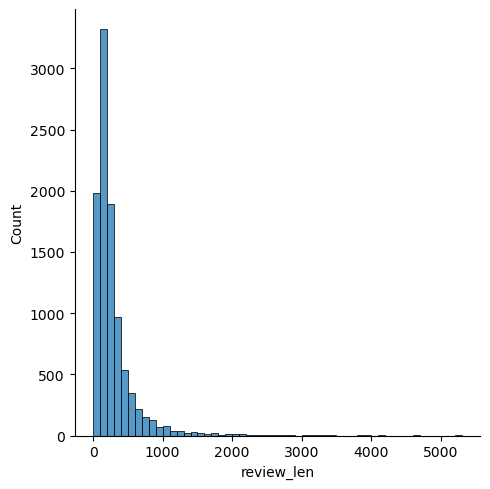

In [39]:
sns.displot(restaurants_reviews["review_len"], binwidth=100)

From the plot above, we can see that the large majority of our reviews are under 1000 characters long, with a smaller portion having between 1000 and 2000 and finally an extremely small partition having over 2000. We can also see that the most common review length is 100-200 characters.

In [40]:
restaurants_reviews[restaurants_reviews['review_len'] > 3000]

,Restaurant,Cuisines,raw_review,Rating,review_len,sents,nr_sents
834,Hyper Local,"American, Chinese, North Indian, Kebab, South Indian",#UNITEDFOODCIRCLE\r\n\r\nDelhi's famous local street food in Hyderabad!!\r\n...,5,3281,"[#UNITEDFOODCIRCLE\r\n\r\nDelhi's famous local street food in Hyderabad!!, H...",2
836,Hyper Local,"American, Chinese, North Indian, Kebab, South Indian",Review :\r\n\r\nRecently we've received an invitation from Hyper Local. It's...,5,4150,"[Review :\r\n\r\nRecently we've received an invitation from Hyper Local., It...",46
1668,NorFest - The Dhaba,North Indian,⚫️ This has to be my favourite Punjabi restaurant in Hyderabad!!! During my ...,4,3294,"[⚫️ This has to be my favourite Punjabi restaurant in Hyderabad!!!, During m...",36
2130,Jonathan's Kitchen - Holiday Inn Express & Suites,"North Indian, Japanese, Italian, Salad, Sushi",A peaceful n quite place is something u want after a hectic schedule where u...,4,5247,[A peaceful n quite place is something u want after a hectic schedule where ...,3
2138,Jonathan's Kitchen - Holiday Inn Express & Suites,"North Indian, Japanese, Italian, Salad, Sushi",Best place Ever Jonathan's Kitchen\r\n\r\nIf you are near Gachibowli and are...,5,3322,[Best place Ever Jonathan's Kitchen\r\n\r\nIf you are near Gachibowli and ar...,33
3030,Pot Pourri,"Andhra, South Indian, North Indian",*Writing this review as soon as I got out of the restaurant*\r\nFrom the beg...,1,3358,[*Writing this review as soon as I got out of the restaurant*\r\nFrom the be...,62
3254,Marsala Food Company,"Arabian, North Indian, Chinese",Recently we were invited for a food tasting session here at Marsala Food Com...,5,3133,[Recently we were invited for a food tasting session here at Marsala Food Co...,34
3263,Marsala Food Company,"Arabian, North Indian, Chinese",Today I visited this place along with a few friends.Located at the third lev...,5,3461,[Today I visited this place along with a few friends.Located at the third le...,9
3429,Mazzo - Marriott Executive Apartments,"Italian, North Indian, South Indian, Asian","As the name suggests, its supposed to be a Marriott and that's what you expe...",1,3007,"[As the name suggests, its supposed to be a Marriott and that's what you exp...",38
3482,Mazzo - Marriott Executive Apartments,"Italian, North Indian, South Indian, Asian",Revised Review:\r\n\r\nIt was an absolute delight to be at Mazzo. The view i...,5,3017,"[Revised Review:\r\n\r\nIt was an absolute delight to be at Mazzo., The view...",41


As we can see from the filtered dataframe, most of these extremely long reviews appear to be actual reviews, as such we won't exclude any of them.

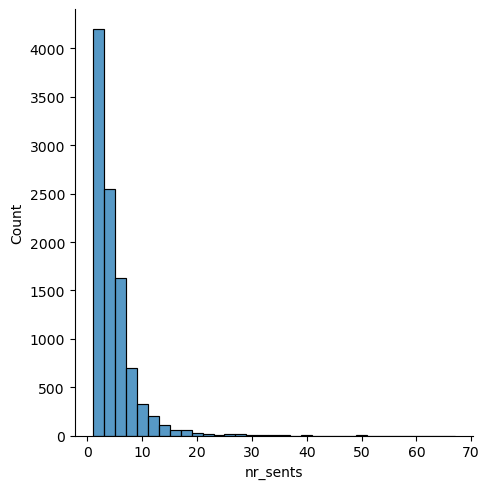

In [41]:
sns.displot(restaurants_reviews["nr_sents"], binwidth=2)


Analysing the plot above we can see that the most common number of sentences for a review is 1 or 2. We can also conclude that the large majority of reviews is less than 20 sentences long.

In [42]:
restaurants_reviews.describe()

,review_len,nr_sents
count,9955.000000,9955.000000
mean,281.458564,4.067403
std,341.622231,4.236098
min,1.000000,1.000000
25%,145.000000,1.000000
50%,190.000000,3.000000
75%,323.000000,5.000000
max,5247.000000,66.000000


Looking at the describe dataframe of the variables, we can see that, on average, reviews are approximately 4 sentences and 281 characters long. It's also possible to conclude that there are some reviews which are 1 character long and some which are up to 5247 characters long, but as we showed above are still actual reviews. We can also see that we have reviews with up to 66 sentences.  

In [43]:
restaurants_reviews[restaurants_reviews['review_len']==1]

,Restaurant,Cuisines,raw_review,Rating,review_len,sents,nr_sents
1583,KFC,"Burger, Fast Food",😄,5,1,[😄],1
2090,13 Dhaba,North Indian,D,5,1,[D],1
3583,Green Bawarchi Restaurant,"North Indian, Chinese, Biryani",5,5,1,[5],1
3736,Kritunga Restaurant,"Andhra, Biryani, Hyderabadi, North Indian",4,4,1,[4],1
3743,Kritunga Restaurant,"Andhra, Biryani, Hyderabadi, North Indian",o,5,1,[o],1
3784,Kritunga Restaurant,"Andhra, Biryani, Hyderabadi, North Indian",.,5,1,[.],1
4281,Karachi Cafe,"Cafe, Desserts, Fast Food",a,5,1,[a],1
4565,Owm Nom Nom,"Chinese, Biryani, Andhra, North Indian",4,3,1,[4],1
4573,Owm Nom Nom,"Chinese, Biryani, Andhra, North Indian",💝,5,1,[💝],1
4582,Owm Nom Nom,"Chinese, Biryani, Andhra, North Indian",😊,5,1,[😊],1


In [44]:
restaurants_reviews  = restaurants_reviews[restaurants_reviews['review_len']>1]

We can see that the 1 character reviews are meaningless, some contain the rating, but most are just random characters including some emojis. As we are likely to remove emojis during the preprocessing stage, we will simply ignore and remove all of these reviews. This results in removing a further 0.19% of our original data. We have still only removed 0.64% of our original data.

We will now obtain a list containing all of the unique cusine types in the dataset. We will first prepare the Cuisines column into lists rather than strings to make it easier to work with.

In [45]:
restaurants_reviews["Cuisines"] = restaurants_reviews["Cuisines"].map(lambda content : re.split(",",re.sub("\s","",content)))



In [46]:
unique_cuisines = []

for cuisine_types_list in list(restaurants_reviews["Cuisines"]):
    for cuisine in cuisine_types_list:
        if cuisine not in unique_cuisines:
            unique_cuisines.append(cuisine)

unique_cuisines.sort()
print(len(unique_cuisines))
print(unique_cuisines)

42
['American', 'Andhra', 'Arabian', 'Asian', 'BBQ', 'Bakery', 'Beverages', 'Biryani', 'Burger', 'Cafe', 'Chinese', 'Continental', 'Desserts', 'European', 'FastFood', 'FingerFood', 'Goan', 'HealthyFood', 'Hyderabadi', 'IceCream', 'Indonesian', 'Italian', 'Japanese', 'Juices', 'Kebab', 'Lebanese', 'Mediterranean', 'Mexican', 'ModernIndian', 'Momos', 'Mughlai', 'NorthEastern', 'NorthIndian', 'Pizza', 'Salad', 'Seafood', 'SouthIndian', 'Spanish', 'StreetFood', 'Sushi', 'Thai', 'Wraps']


We can see that we have 42 unique cuisine types.

Now, we will use an auxiliary dataframe to help us to obtain and plot the counts for each cuisine types.

In [47]:
restaurants_reviews_explore = pd.DataFrame()
restaurants_reviews_explore["Cuisines"] = restaurants_reviews["Cuisines"]

for label in unique_cuisines:
    restaurants_reviews_explore[f"has_{label}_cuisine"] = restaurants_reviews["Cuisines"].map(lambda labels_list : 1 if label in labels_list else 0)

In [48]:
labels =  restaurants_reviews_explore[restaurants_reviews_explore.columns[restaurants_reviews_explore.columns.str.startswith('has_')]]
label_counts = labels.sum().sort_values(ascending=False)
display(label_counts)

has_NorthIndian_cuisine      5980
has_Chinese_cuisine          4085
has_Continental_cuisine      2084
has_Biryani_cuisine          1489
has_Italian_cuisine          1400
has_Asian_cuisine            1400
has_Desserts_cuisine         1298
has_FastFood_cuisine         1271
has_SouthIndian_cuisine       899
has_Bakery_cuisine            600
has_Mughlai_cuisine           600
has_Kebab_cuisine             600
has_Cafe_cuisine              599
has_Andhra_cuisine            594
has_American_cuisine          576
has_Mediterranean_cuisine     500
has_Beverages_cuisine         500
has_Burger_cuisine            475
has_Momos_cuisine             400
has_Sushi_cuisine             400
has_European_cuisine          400
has_Seafood_cuisine           398
has_Hyderabadi_cuisine        395
has_Salad_cuisine             377
has_FingerFood_cuisine        200
has_Thai_cuisine              200
has_StreetFood_cuisine        200
has_Arabian_cuisine           200
has_BBQ_cuisine               200
has_ModernIndi

In [49]:
restaurants_reviews_explore.describe()

,has_American_cuisine,has_Andhra_cuisine,has_Arabian_cuisine,has_Asian_cuisine,has_BBQ_cuisine,has_Bakery_cuisine,has_Beverages_cuisine,has_Biryani_cuisine,has_Burger_cuisine,has_Cafe_cuisine,...,has_NorthIndian_cuisine,has_Pizza_cuisine,has_Salad_cuisine,has_Seafood_cuisine,has_SouthIndian_cuisine,has_Spanish_cuisine,has_StreetFood_cuisine,has_Sushi_cuisine,has_Thai_cuisine,has_Wraps_cuisine
count,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,...,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000,9936.000000
mean,0.057971,0.059783,0.020129,0.140902,0.020129,0.060386,0.050322,0.149859,0.047806,0.060286,...,0.601852,0.009863,0.037943,0.040056,0.090479,0.010064,0.020129,0.040258,0.020129,0.010064
std,0.233700,0.237096,0.140448,0.347938,0.140448,0.238213,0.218620,0.356951,0.213366,0.238028,...,0.489541,0.098827,0.191068,0.196101,0.286881,0.099820,0.140448,0.196573,0.140448,0.099820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


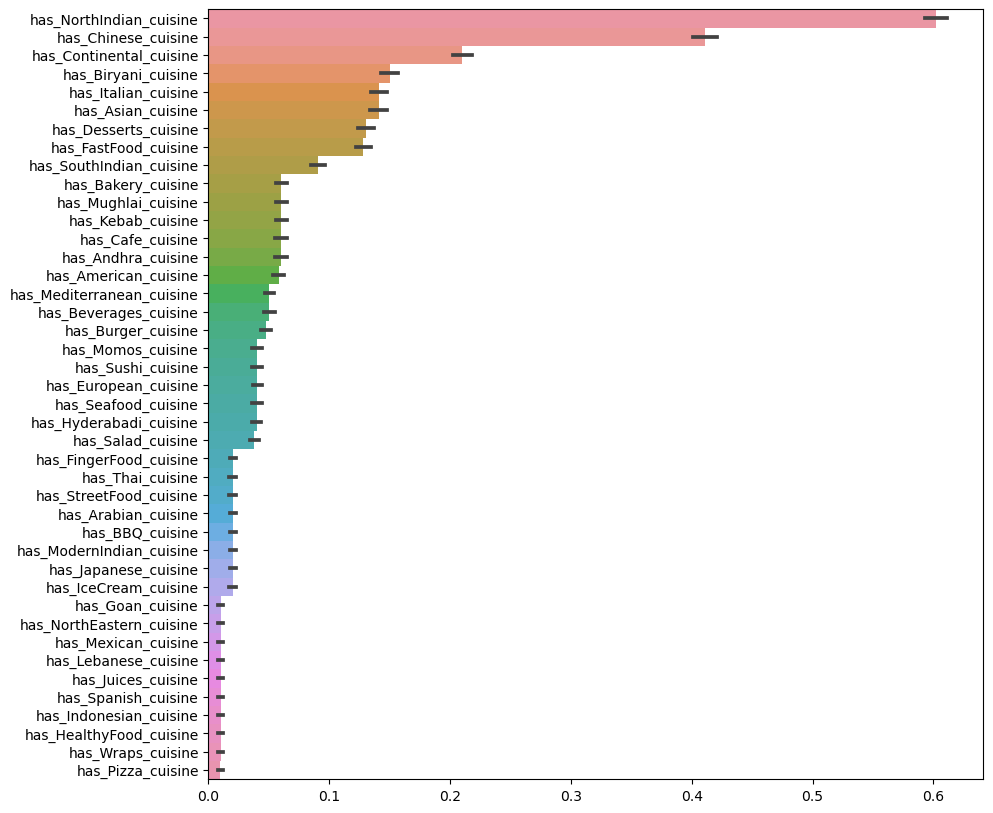

In [50]:
plt.figure(figsize=(10, 10))
sns.barplot(data=labels, orient="h", width=1, order=list(label_counts.index))

plt.show()


There are some take-aways from the plot above:
+ As expected, due to the region our data originates from, we can see that asian cuisines are much more common than western ones. With the most commonly reviewed cuisine type being North Indian, the second most common being Chinese, Continental in third and Biryani in fourth. 
+ Interestingly, Italian cuisine is quite high on the list, this may be due to it being more internationally recognizable than other western cuisines. 
+ We can also see that latin cuisines (excluding Italian) are very seldom reviewed. The least reviewed cuisine is Pizza, which makes some sense since it can actually be seen as a subdivision of Italian cuisine and, thus, it may simply be more specific than other cuisines present on the list. 
+ The healthy food cuisine also contains very few reviews, this could be due to the people in this particular region being less conscious/worried about healthy eating habits, compared to western cultures.
+ The distribution is, as expected, unbalanced, as such we'll use techniques like stratification, class weights and evaluating with F1-score to attempt to mitigate this unbalance.

## 3.2. Wordclouds

[Back to TOC](#toc)



We will now create wordclouds for each cuisine type to check for differences and get an idea of which cuisines our model should be able to predict more easily. For this purpose we will perform full preprocessing, except for lemmatization, tokenization and POS tagging.

In [21]:
preprocessor = pipeline_v2.MainPipeline()
restaurants_reviews['preproc_review'] = restaurants_reviews['raw_review'].map(lambda content : preprocessor.main_pipeline(content))
restaurants_reviews['preproc_review']

0       ambience good food quite good saturday lunch cost effective good place sate ...
1       ambience good pleasant evening service prompt food good good experience soum...
2       must try great food great ambience thnx service pradeep subroto personal rec...
3       soumen da arun great guy behavior sincerety good food course would like visi...
4       food ordered kodi drumstick basket mutton biryani good thanks pradeep served...
                                             ...                                       
9995    madhumathi mahajan well start nice courteous server staff excellent serving ...
9996    place never disappointed u food courteous staff serene ambience wanted somet...
9997    bad rating mainly chicken bone found veg food acceptable vegetarian satiate ...
9998    personally love prefer chinese food couple time husband ambiance place good ...
9999    checked try delicious chinese food seen non-veg luncheon tray menu an tried ...
Name: preproc_review, Length: 99

In [22]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

In [23]:
corpus = []
for cuisine in unique_cuisines:
    cuisine_doc = ""
    for review in restaurants_reviews["preproc_review"].loc[restaurants_reviews_explore[f"has_{cuisine}_cuisine"]==1]:        
        cuisine_doc = cuisine_doc + " " + review
    corpus.append(cuisine_doc)

print(f"Length of unique_genres: {len(unique_cuisines)}; Length of corpus: {len(corpus)}")

Length of unique_genres: 42; Length of corpus: 42


In [24]:
folder_path = "word_clouds/cuisines"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for idx, document in enumerate(corpus):
    cuisine_corpus_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(corpus)
    cuisine_corpus_tfidf_word_list = bigram_tfidf_vectorizer.get_feature_names_out()

    genre_tfidf_corpus_vocabulary = pipeline_v2.word_freq_calculator(cuisine_corpus_tfidf_td_matrix[idx].toarray(),\
                                                                        cuisine_corpus_tfidf_word_list, df_output=False)
    wc.generate_from_frequencies(genre_tfidf_corpus_vocabulary)
    wc.to_file(os.path.join(folder_path, "WC_"+unique_cuisines[idx]+"_TFIDF.png"))

As we have 42 unique cuisines, we will obviously not display the wordclouds in this notebook, they can be found in the "word_clouds/cuisines" folder. We will however draw some conclusions from analysing them:
+ Words like "good", "food", "place" and "service" are quite common across all cuisine types
+ The word "chicken" also appears frequently across a few cuisines, which makes sense as most of the cuisines present in our data have some type of chicken dish.
+ Beverages, Cafe and Dessert cuisine types have a lot of common terms across them, such as "cake", "donut" and "coffee", this makes sense as these 3 cuisine types are obviously closely related to each other.
+ Pizza cuisine has a very distinct vocabulary with terms like "pizza", "dominos", "order" and "delivery", this make sense as pizza restaurants traditionally do a lot of their business through deliveries.
+ The Ice Cream cuisine also contains a unique set of terms, such as "ice cream", "chocolate", "nut" and "cream", these are mostly unique to this cuisine.
+ The remaining cuisines have some differentiating factors but are not as distinguishable as the ones described above.

With all of this in mind, we believe that our models should be able to find some patterns, but will struggle to have high scores.

# 4. Modelling

[Back to TOC](#toc)

We will now begin creating models. We will test 4 feature extraction methods: Doc2Vec, TF-IDF, BagOfWords and BERT tokenizer. For TF-IDF and BagOfWords, we will test full prepocessing (i.e. stopword, punctuation, html tag, etc. removal) with and without 
lemmatization, we performed some testing and including stopwords or punctuation did not improve results, this testing is not included in the report or notebooks. 

We will test ClassifierChain and OneVsRest classifiers with RandomForestClassifiers and LogisticRegressions. For the ClassifierChains we will always use order descending, which means the first model predicts the most common class and the last model predicts the least common class, this is based on the assumption that minority classes will benefit more from taking as input in their corresponding models the previous prediction and the relationships between them, and we will pass the prediction probabilities rather than the actual predictions between models, these methods provide better results from some testing.

In [51]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(restaurants_reviews["Cuisines"])
restaurants_reviews["label_binary"] = binarised_labels.tolist()
restaurants_reviews[["Cuisines", "label_binary"]]

,Cuisines,label_binary
0,"[Chinese, Continental, Kebab, European, SouthIndian, NorthIndian]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,"[Chinese, Continental, Kebab, European, SouthIndian, NorthIndian]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,"[Chinese, Continental, Kebab, European, SouthIndian, NorthIndian]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,"[Chinese, Continental, Kebab, European, SouthIndian, NorthIndian]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,"[Chinese, Continental, Kebab, European, SouthIndian, NorthIndian]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...
9995,"[Chinese, Seafood]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9996,"[Chinese, Seafood]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9997,"[Chinese, Seafood]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9998,"[Chinese, Seafood]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [52]:
descending = [unique_cuisines.index(cuisine[4:-8]) for cuisine in label_counts.index]
descending

[32,
 10,
 11,
 7,
 21,
 3,
 12,
 14,
 36,
 5,
 30,
 24,
 9,
 1,
 0,
 26,
 6,
 8,
 29,
 39,
 13,
 35,
 18,
 34,
 15,
 40,
 38,
 2,
 4,
 28,
 22,
 19,
 16,
 31,
 27,
 25,
 23,
 37,
 20,
 17,
 41,
 33]

We will define some functions to give us more robust and more interpretable results. We will use the hermetic classifier from class to perform crossvalidation with our models, preprocessors and vectorizers.

Note: The fold_score_calculator and HermeticClassifier used are taken from class and adapted slightly for our use. 

In [53]:
def fold_score_calculator(y_pred, y_test, verbose=False):
    
    # Compute the binary classification scores (accuracy, precision, recall, F1, AUC) for the fold.
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = metrics.recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1_weighted = metrics.f1_score(y_test, y_pred, average="weighted", zero_division=0)
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro", zero_division=0)
    if verbose == True:
        report = metrics.classification_report(y_test, y_pred, target_names=unique_cuisines)
        print("Accuracy: {} \nPrecision: {} \nRecall: {} \nWeighted F1: {}\nMacro F1: {}".format(acc,prec,recall,f1_weighted, f1_macro))
        print(report)
    return (acc, prec, recall, f1_weighted, f1_macro)

In [54]:
class HermeticClassifier(ClassifierMixin, BaseEstimator):

    def __init__(self, preprocessor, vectorizer, classifier, d2v_vector_size, d2v_window, **kwargs):
        self.preprocessor = preprocessor
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.d2v_vector_size = d2v_vector_size
        self.d2v_window = d2v_window

    @property
    def classes_(self):
        return self.classifier.classes_

    def fit(self, X, y, **kwargs):

        X_preproc = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X]

        try:
            X_train = self.vectorizer.fit_transform(X_preproc)
        except AttributeError:
            if self.d2v_vector_size and self.d2v_window:
                documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(X)]
                self.d2v_model = self.vectorizer(documents, vector_size=self.d2v_vector_size, window=self.d2v_window, min_count=1, workers=4)
                X_train = [self.d2v_model.dv[idx].tolist() for idx in range(len(X_preproc))]
            else:
                X_train = [self.vectorizer.encode(review, truncation=True, max_length=512, padding='max_length') for review in X_preproc]
                

        y_train = y
            
        try:
            X_train = X_train.toarray()
        except AttributeError:
            pass
        try:
            y_train = y_train.to_numpy()
        except AttributeError:
            pass


        self.classifier.fit(X_train, y_train)

        self.X_ = X_train
        self.y_ = y_train

        return self

    def predict(self, X_test_raw, **kwargs):

        # Check if fit has been called
        check_is_fitted(self)

        X_test = [self.preprocessor.main_pipeline(doc, **kwargs) for doc in X_test_raw]
 
        try:
            X_test = self.vectorizer.transform(X_test)
        except AttributeError:
            if self.d2v_vector_size and self.d2v_window:
                X_test = [self.d2v_model.infer_vector(word_tokenize(content)).tolist() for content in X_test]
            else: 
                X_test = [self.vectorizer.encode(review, truncation=True, max_length=512, padding='max_length') for review in X_test]

        try:
            X_test = check_array(X_test.toarray())
        except AttributeError:
            X_test = check_array(X_test)
            
        y_pred = self.classifier.predict(X_test)

        return y_pred


In [55]:
def cv_scores(X, y, X_test, y_test, preprocessor, vectorizer, classifier, d2v_vector_size=None, d2v_window=None,
                   cv=IterativeStratification(n_splits=5), **kwargs):
    classifier = HermeticClassifier(preprocessor, vectorizer, classifier, d2v_vector_size, d2v_window, **kwargs)
    macro_f1_train = []
    macro_f1_val = []
    weighted_f1_train = []
    weighted_f1_val = []
    fold_n = 1
    for train_index, val_index in cv.split(X,y):
        # Split
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        # Fit and Predict (this will take care of all preparatory steps)
        modelfit = classifier.fit(X_train, y_train)
        pred_train = modelfit.predict(X_train)
        pred_val = modelfit.predict(X_val)
        # Calculate and F1 scores
        fold_scores_train = fold_score_calculator(pred_train, y_train)
        fold_scores_val = fold_score_calculator(pred_val, y_val)
        macro_f1_train.append(round(fold_scores_train[4],4))
        weighted_f1_train.append(round(fold_scores_train[3],4))
        macro_f1_val.append(round(fold_scores_val[4],4))
        weighted_f1_val.append(round(fold_scores_val[3],4))
        print(f"Fold {fold_n}:\n\nWeighted Train F1: {weighted_f1_train[fold_n-1]}\nWeighted Validation F1: {weighted_f1_val[fold_n-1]}\n")
        print(f"Macro Train F1: {macro_f1_train[fold_n-1]}\nMacro Validation F1: {macro_f1_val[fold_n-1]}\n")
        fold_n += 1
    weighted_f1_train_mean = round(np.mean(weighted_f1_train),4)
    weighted_f1_val_mean = round(np.mean(weighted_f1_val),4)
    macro_f1_train_mean = round(np.mean(macro_f1_train),4)
    macro_f1_val_mean = round(np.mean(macro_f1_val),4)
    print(f"Final Scores:\n\nMean Weighted Train F1: {weighted_f1_train_mean}\nMean Weighted Validation F1: {weighted_f1_val_mean}\n")
    print(f"Mean Macro Train F1: {macro_f1_train_mean}\nMean Macro Validation F1: {macro_f1_val_mean}\n")
    # We'll use the model from the final split to evaluate the model on the test set.
    pred_test = classifier.predict(X_test)
    fold_score_calculator(pred_test, y_test, verbose=True)    





We will now define the preprocessors we'll use.  
+ We'll have two preprocessors for BoW and TF-IDF and BertTokenizer, both perform full preprocessing (i.e. stopword, punctuation and tag removal, ect.) but on uses lemmatization and the other one does not.
+ We'll then have a preprocessor for Doc2Vec, which does not remove stopwords and doesn't lemmatize in an attempt to preserve context.


In [56]:
base_preprocessor = pipeline_v2.MainPipeline()
lemmatization_preprocessor = pipeline_v2.MainPipeline(lemmatized=True)
preprocessor_d2v = pipeline_v2.MainPipeline(no_stopwords=False)

Now, we'll define the vectorizers:
+ Unigram TF-IDF vectorizer, because bigrams resulted in memory errors;
+ Unigram BagOfWords vectorizer, because bigrams resulted in memory errors;
+ A Doc2Vec, we'll  use it within the HermeticClassifier;
+ Finally, we'll also test BertTokenizer.

In [57]:
unigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
unigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
d2v_vectorizer = Doc2Vec
bert_tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

We won't touch the vectorization parameters for Doc2Vec and BertTokenizer too much, because the initial results are extremely poor.

Finally, we'll define the classifiers:
+ A LogisticRegression ClassifierChain as described above;
+ A LogisticRegression OneVsRestClassifier.
+ A RandomForestClassifier ClassifierChain as described above;
+ A RandomForestClassifier OneVsRestClassifier.


Both will use balanced class weights, random_state 0 and the lbfgs solver (for the LogisticRegression).

In [58]:
lr_chain = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order=descending, chain_method='predict_proba')
lr_ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"))
rf_chain = ClassifierChain(RandomForestClassifier(random_state=0, class_weight="balanced"), order=descending, chain_method='predict_proba')
rf_ovr = OneVsRestClassifier(RandomForestClassifier(random_state=0, class_weight="balanced"))

We will now split our data into train (which will be used for crossvalidation) and test (which will be used to evaluate and compare model performance).

In [59]:
X_train, X_test, y_train, y_test = train_test_split(restaurants_reviews['raw_review'], binarised_labels,
                                                    test_size=0.2, random_state=0, stratify=binarised_labels)

As this is a testing phase, we will not analyzie any results, we'll simply choose the best model and perform a final evaluation on that model.

## 4.1. TF-IDF

[Back to TOC](#toc)


### Logistic Regression Classifier Chain

In [34]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_tfidf_vectorizer, lr_chain)

Fold 1:

Weighted Train F1: 0.5684
Weighted Validation F1: 0.4666

Macro Train F1: 0.2824
Macro Validation F1: 0.2142

Fold 2:

Weighted Train F1: 0.5708
Weighted Validation F1: 0.4535

Macro Train F1: 0.2888
Macro Validation F1: 0.2041

Fold 3:

Weighted Train F1: 0.5641
Weighted Validation F1: 0.4569

Macro Train F1: 0.2829
Macro Validation F1: 0.189

Fold 4:

Weighted Train F1: 0.5624
Weighted Validation F1: 0.4634

Macro Train F1: 0.2801
Macro Validation F1: 0.1996

Fold 5:

Weighted Train F1: 0.564
Weighted Validation F1: 0.4691

Macro Train F1: 0.284
Macro Validation F1: 0.2008

Final Scores:

Mean Weighted Train F1: 0.5659
Mean Weighted Validation F1: 0.4619

Mean Macro Train F1: 0.2836
Mean Macro Validation F1: 0.2015

Accuracy: 0.11569416498993963 
Precision: 0.6719847986139884 
Recall: 0.4364973262032086 
Weighted F1: 0.45182905987851546
Macro F1: 0.20854563411145963
               precision    recall  f1-score   support

     American       1.00      0.03      0.07       115

### Logistic Regression Classifier Chain with Lemmatization

In [35]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_tfidf_vectorizer, lr_chain)

Fold 1:

Weighted Train F1: 0.5671
Weighted Validation F1: 0.4575

Macro Train F1: 0.2817
Macro Validation F1: 0.1992

Fold 2:

Weighted Train F1: 0.564
Weighted Validation F1: 0.471

Macro Train F1: 0.2831
Macro Validation F1: 0.199

Fold 3:

Weighted Train F1: 0.5697
Weighted Validation F1: 0.4538

Macro Train F1: 0.2896
Macro Validation F1: 0.2043

Fold 4:

Weighted Train F1: 0.5671
Weighted Validation F1: 0.4624

Macro Train F1: 0.2832
Macro Validation F1: 0.2086

Fold 5:

Weighted Train F1: 0.5661
Weighted Validation F1: 0.4708

Macro Train F1: 0.2842
Macro Validation F1: 0.2042

Final Scores:

Mean Weighted Train F1: 0.5668
Mean Weighted Validation F1: 0.4631

Mean Macro Train F1: 0.2844
Mean Macro Validation F1: 0.2031

Accuracy: 0.10865191146881288 
Precision: 0.6763478404579479 
Recall: 0.43816844919786097 
Weighted F1: 0.45076665139490524
Macro F1: 0.20729491615313003
               precision    recall  f1-score   support

     American       1.00      0.06      0.11       11

### Logistic Regression OnevsRest

In [36]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_tfidf_vectorizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.7422
Weighted Validation F1: 0.5597

Macro Train F1: 0.6534
Macro Validation F1: 0.3717

Fold 2:

Weighted Train F1: 0.7421
Weighted Validation F1: 0.5613

Macro Train F1: 0.6544
Macro Validation F1: 0.3987

Fold 3:

Weighted Train F1: 0.7406
Weighted Validation F1: 0.5585

Macro Train F1: 0.6488
Macro Validation F1: 0.4066

Fold 4:

Weighted Train F1: 0.741
Weighted Validation F1: 0.561

Macro Train F1: 0.6522
Macro Validation F1: 0.4102

Fold 5:

Weighted Train F1: 0.7426
Weighted Validation F1: 0.5677

Macro Train F1: 0.6594
Macro Validation F1: 0.4044

Final Scores:

Mean Weighted Train F1: 0.7417
Mean Weighted Validation F1: 0.5616

Mean Macro Train F1: 0.6536
Mean Macro Validation F1: 0.3983

Accuracy: 0.10462776659959759 
Precision: 0.485771757034721 
Recall: 0.6615975935828877 
Weighted F1: 0.5491948964924124
Macro F1: 0.39507347627887285
               precision    recall  f1-score   support

     American       0.49      0.62      0.55       115


### Logistic Regression OnevsRest with Lemmatization

In [37]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_tfidf_vectorizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.7433
Weighted Validation F1: 0.5597

Macro Train F1: 0.6565
Macro Validation F1: 0.3971

Fold 2:

Weighted Train F1: 0.7464
Weighted Validation F1: 0.5575

Macro Train F1: 0.6612
Macro Validation F1: 0.3897

Fold 3:

Weighted Train F1: 0.7403
Weighted Validation F1: 0.5649

Macro Train F1: 0.6545
Macro Validation F1: 0.3929

Fold 4:

Weighted Train F1: 0.7414
Weighted Validation F1: 0.5536

Macro Train F1: 0.648
Macro Validation F1: 0.3881

Fold 5:

Weighted Train F1: 0.7383
Weighted Validation F1: 0.5687

Macro Train F1: 0.6477
Macro Validation F1: 0.4145

Final Scores:

Mean Weighted Train F1: 0.7419
Mean Weighted Validation F1: 0.5609

Mean Macro Train F1: 0.6536
Mean Macro Validation F1: 0.3965

Accuracy: 0.1141851106639839 
Precision: 0.48924067611809524 
Recall: 0.6656082887700535 
Weighted F1: 0.5531838826890392
Macro F1: 0.39593475593028016
               precision    recall  f1-score   support

     American       0.47      0.62      0.54       11

### Random Forest Classifier Chain

In [38]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_tfidf_vectorizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9589
Weighted Validation F1: 0.363

Macro Train F1: 0.9566
Macro Validation F1: 0.1456

Fold 2:

Weighted Train F1: 0.9589
Weighted Validation F1: 0.3591

Macro Train F1: 0.9566
Macro Validation F1: 0.1371

Fold 3:

Weighted Train F1: 0.9602
Weighted Validation F1: 0.3771

Macro Train F1: 0.9573
Macro Validation F1: 0.143

Fold 4:

Weighted Train F1: 0.9636
Weighted Validation F1: 0.3484

Macro Train F1: 0.9653
Macro Validation F1: 0.1134

Fold 5:

Weighted Train F1: 0.9599
Weighted Validation F1: 0.362

Macro Train F1: 0.9589
Macro Validation F1: 0.1467

Final Scores:

Mean Weighted Train F1: 0.9603
Mean Weighted Validation F1: 0.3619

Mean Macro Train F1: 0.9589
Mean Macro Validation F1: 0.1372

Accuracy: 0.09356136820925554 
Precision: 0.536630220746173 
Recall: 0.3447526737967914 
Weighted F1: 0.35424117015207124
Macro F1: 0.1357885672078451
               precision    recall  f1-score   support

     American       0.71      0.09      0.16       115
 

### Random Forest Classifier Chain with Lemmatization

In [39]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_tfidf_vectorizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9585
Weighted Validation F1: 0.3574

Macro Train F1: 0.9575
Macro Validation F1: 0.1394

Fold 2:

Weighted Train F1: 0.9586
Weighted Validation F1: 0.3773

Macro Train F1: 0.9589
Macro Validation F1: 0.1439

Fold 3:

Weighted Train F1: 0.9626
Weighted Validation F1: 0.3654

Macro Train F1: 0.9597
Macro Validation F1: 0.131

Fold 4:

Weighted Train F1: 0.9601
Weighted Validation F1: 0.3661

Macro Train F1: 0.9581
Macro Validation F1: 0.14

Fold 5:

Weighted Train F1: 0.9603
Weighted Validation F1: 0.3569

Macro Train F1: 0.9576
Macro Validation F1: 0.1328

Final Scores:

Mean Weighted Train F1: 0.96
Mean Weighted Validation F1: 0.3646

Mean Macro Train F1: 0.9584
Mean Macro Validation F1: 0.1374

Accuracy: 0.1011066398390342 
Precision: 0.5372843505058484 
Recall: 0.3449197860962567 
Weighted F1: 0.35421132984307074
Macro F1: 0.13108177343063712
               precision    recall  f1-score   support

     American       0.56      0.09      0.15       115
  

### Random Forest OnevsRest

In [40]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_tfidf_vectorizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9271
Weighted Validation F1: 0.3329

Macro Train F1: 0.8824
Macro Validation F1: 0.1083

Fold 2:

Weighted Train F1: 0.9301
Weighted Validation F1: 0.3375

Macro Train F1: 0.8794
Macro Validation F1: 0.1063

Fold 3:

Weighted Train F1: 0.925
Weighted Validation F1: 0.3462

Macro Train F1: 0.8719
Macro Validation F1: 0.1107

Fold 4:

Weighted Train F1: 0.929
Weighted Validation F1: 0.3351

Macro Train F1: 0.8808
Macro Validation F1: 0.1077

Fold 5:

Weighted Train F1: 0.9295
Weighted Validation F1: 0.3392

Macro Train F1: 0.882
Macro Validation F1: 0.1125

Final Scores:

Mean Weighted Train F1: 0.9281
Mean Weighted Validation F1: 0.3382

Mean Macro Train F1: 0.8793
Mean Macro Validation F1: 0.1091

Accuracy: 0.07344064386317907 
Precision: 0.4880893602219136 
Recall: 0.3153409090909091 
Weighted F1: 0.3258588951711026
Macro F1: 0.10001300387132168
               precision    recall  f1-score   support

     American       0.33      0.03      0.06       115


### Random Forest OnevsRest with Lemmatization

In [41]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_tfidf_vectorizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9289
Weighted Validation F1: 0.3469

Macro Train F1: 0.8771
Macro Validation F1: 0.1157

Fold 2:

Weighted Train F1: 0.9262
Weighted Validation F1: 0.3425

Macro Train F1: 0.8731
Macro Validation F1: 0.1099

Fold 3:

Weighted Train F1: 0.9263
Weighted Validation F1: 0.3414

Macro Train F1: 0.8816
Macro Validation F1: 0.1099

Fold 4:

Weighted Train F1: 0.9295
Weighted Validation F1: 0.3345

Macro Train F1: 0.8744
Macro Validation F1: 0.1076

Fold 5:

Weighted Train F1: 0.9228
Weighted Validation F1: 0.34

Macro Train F1: 0.8701
Macro Validation F1: 0.1104

Final Scores:

Mean Weighted Train F1: 0.9267
Mean Weighted Validation F1: 0.3411

Mean Macro Train F1: 0.8753
Mean Macro Validation F1: 0.1107

Accuracy: 0.06891348088531186 
Precision: 0.4986239457308476 
Recall: 0.32637032085561496 
Weighted F1: 0.33138718361228753
Macro F1: 0.10468272699698862
               precision    recall  f1-score   support

     American       0.25      0.03      0.05       1

## 4.2. Bag Of Words

[Back to TOC](#toc)


### Logistic Regression Classifier Chain

In [42]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_bow_vectorizer, lr_chain)

Fold 1:

Weighted Train F1: 0.8805
Weighted Validation F1: 0.5553

Macro Train F1: 0.8634
Macro Validation F1: 0.4233

Fold 2:

Weighted Train F1: 0.8812
Weighted Validation F1: 0.5698

Macro Train F1: 0.8622
Macro Validation F1: 0.4099

Fold 3:

Weighted Train F1: 0.8832
Weighted Validation F1: 0.5507

Macro Train F1: 0.8694
Macro Validation F1: 0.406

Fold 4:

Weighted Train F1: 0.8806
Weighted Validation F1: 0.5661

Macro Train F1: 0.8629
Macro Validation F1: 0.4261

Fold 5:

Weighted Train F1: 0.8824
Weighted Validation F1: 0.5434

Macro Train F1: 0.8642
Macro Validation F1: 0.3962

Final Scores:

Mean Weighted Train F1: 0.8816
Mean Weighted Validation F1: 0.5571

Mean Macro Train F1: 0.8644
Mean Macro Validation F1: 0.4123

Accuracy: 0.1790744466800805 
Precision: 0.6199184045190365 
Recall: 0.5233957219251337 
Weighted F1: 0.55176695251857
Macro F1: 0.42443060509022634
               precision    recall  f1-score   support

     American       0.82      0.39      0.53       115
 

### Logistic Regression Classifier Chain with Lemmatization

In [43]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_bow_vectorizer, lr_chain)

Fold 1:

Weighted Train F1: 0.8803
Weighted Validation F1: 0.5593

Macro Train F1: 0.8646
Macro Validation F1: 0.4225

Fold 2:

Weighted Train F1: 0.8839
Weighted Validation F1: 0.5522

Macro Train F1: 0.8676
Macro Validation F1: 0.4072

Fold 3:

Weighted Train F1: 0.8807
Weighted Validation F1: 0.5591

Macro Train F1: 0.8625
Macro Validation F1: 0.4238

Fold 4:

Weighted Train F1: 0.8827
Weighted Validation F1: 0.5582

Macro Train F1: 0.8662
Macro Validation F1: 0.4135

Fold 5:

Weighted Train F1: 0.8801
Weighted Validation F1: 0.5719

Macro Train F1: 0.8605
Macro Validation F1: 0.4306

Final Scores:

Mean Weighted Train F1: 0.8815
Mean Weighted Validation F1: 0.5601

Mean Macro Train F1: 0.8643
Mean Macro Validation F1: 0.4195

Accuracy: 0.1574446680080483 
Precision: 0.6130842953966791 
Recall: 0.5137032085561497 
Weighted F1: 0.5455104700437239
Macro F1: 0.417976322759919
               precision    recall  f1-score   support

     American       0.81      0.40      0.53       115


### Logistic Regression OnevsRest

In [44]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_bow_vectorizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.8574
Weighted Validation F1: 0.5412

Macro Train F1: 0.7992
Macro Validation F1: 0.3705

Fold 2:

Weighted Train F1: 0.8561
Weighted Validation F1: 0.5484

Macro Train F1: 0.7943
Macro Validation F1: 0.3811

Fold 3:

Weighted Train F1: 0.8585
Weighted Validation F1: 0.5505

Macro Train F1: 0.7994
Macro Validation F1: 0.3663

Fold 4:

Weighted Train F1: 0.8574
Weighted Validation F1: 0.5623

Macro Train F1: 0.8061
Macro Validation F1: 0.3784

Fold 5:

Weighted Train F1: 0.8612
Weighted Validation F1: 0.5465

Macro Train F1: 0.803
Macro Validation F1: 0.3672

Final Scores:

Mean Weighted Train F1: 0.8581
Mean Weighted Validation F1: 0.5498

Mean Macro Train F1: 0.8004
Mean Macro Validation F1: 0.3727

Accuracy: 0.11317907444668009 
Precision: 0.49680947414323473 
Recall: 0.6126336898395722 
Weighted F1: 0.5400073048698055
Macro F1: 0.3737857660953332
               precision    recall  f1-score   support

     American       0.51      0.54      0.53       11

### Logistic Regression OnevsRest with Lemmatization

In [45]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_bow_vectorizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.8558
Weighted Validation F1: 0.5478

Macro Train F1: 0.7985
Macro Validation F1: 0.3725

Fold 2:

Weighted Train F1: 0.8583
Weighted Validation F1: 0.538

Macro Train F1: 0.7951
Macro Validation F1: 0.3546

Fold 3:

Weighted Train F1: 0.8569
Weighted Validation F1: 0.5478

Macro Train F1: 0.8006
Macro Validation F1: 0.3678

Fold 4:

Weighted Train F1: 0.8601
Weighted Validation F1: 0.5573

Macro Train F1: 0.8098
Macro Validation F1: 0.3946

Fold 5:

Weighted Train F1: 0.8622
Weighted Validation F1: 0.5493

Macro Train F1: 0.8021
Macro Validation F1: 0.3761

Final Scores:

Mean Weighted Train F1: 0.8587
Mean Weighted Validation F1: 0.548

Mean Macro Train F1: 0.8012
Mean Macro Validation F1: 0.3731

Accuracy: 0.11016096579476861 
Precision: 0.49590173742712473 
Recall: 0.6124665775401069 
Weighted F1: 0.5398177227534969
Macro F1: 0.37483363258858793
               precision    recall  f1-score   support

     American       0.48      0.50      0.49       11

### Random Forest Classifier Chain

In [46]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_bow_vectorizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9611
Weighted Validation F1: 0.3681

Macro Train F1: 0.9623
Macro Validation F1: 0.1466

Fold 2:

Weighted Train F1: 0.9604
Weighted Validation F1: 0.3759

Macro Train F1: 0.9561
Macro Validation F1: 0.143

Fold 3:

Weighted Train F1: 0.96
Weighted Validation F1: 0.3675

Macro Train F1: 0.9598
Macro Validation F1: 0.1491

Fold 4:

Weighted Train F1: 0.9599
Weighted Validation F1: 0.363

Macro Train F1: 0.9599
Macro Validation F1: 0.1327

Fold 5:

Weighted Train F1: 0.9607
Weighted Validation F1: 0.3862

Macro Train F1: 0.958
Macro Validation F1: 0.159

Final Scores:

Mean Weighted Train F1: 0.9604
Mean Weighted Validation F1: 0.3721

Mean Macro Train F1: 0.9592
Mean Macro Validation F1: 0.1461

Accuracy: 0.1056338028169014 
Precision: 0.5588925333086677 
Recall: 0.3465909090909091 
Weighted F1: 0.3611723186222944
Macro F1: 0.1450213598711246
               precision    recall  f1-score   support

     American       0.56      0.12      0.20       115
     

### Random Forest Classifier Chain with Lemmatization

In [47]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_bow_vectorizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9614
Weighted Validation F1: 0.3907

Macro Train F1: 0.9602
Macro Validation F1: 0.1652

Fold 2:

Weighted Train F1: 0.9601
Weighted Validation F1: 0.373

Macro Train F1: 0.9584
Macro Validation F1: 0.1429

Fold 3:

Weighted Train F1: 0.9599
Weighted Validation F1: 0.36

Macro Train F1: 0.9589
Macro Validation F1: 0.1368

Fold 4:

Weighted Train F1: 0.9609
Weighted Validation F1: 0.3714

Macro Train F1: 0.9619
Macro Validation F1: 0.1371

Fold 5:

Weighted Train F1: 0.9616
Weighted Validation F1: 0.3738

Macro Train F1: 0.9589
Macro Validation F1: 0.1577

Final Scores:

Mean Weighted Train F1: 0.9608
Mean Weighted Validation F1: 0.3738

Mean Macro Train F1: 0.9597
Mean Macro Validation F1: 0.1479

Accuracy: 0.10613682092555332 
Precision: 0.5614575446217906 
Recall: 0.3604612299465241 
Weighted F1: 0.37146045043746706
Macro F1: 0.1454858280644044
               precision    recall  f1-score   support

     American       0.52      0.10      0.16       115


### Random Forest OnevsRest

In [48]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, unigram_bow_vectorizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9272
Weighted Validation F1: 0.3546

Macro Train F1: 0.8779
Macro Validation F1: 0.1242

Fold 2:

Weighted Train F1: 0.9286
Weighted Validation F1: 0.3498

Macro Train F1: 0.8809
Macro Validation F1: 0.1197

Fold 3:

Weighted Train F1: 0.9285
Weighted Validation F1: 0.3469

Macro Train F1: 0.882
Macro Validation F1: 0.1133

Fold 4:

Weighted Train F1: 0.9265
Weighted Validation F1: 0.3443

Macro Train F1: 0.8753
Macro Validation F1: 0.1146

Fold 5:

Weighted Train F1: 0.9256
Weighted Validation F1: 0.3457

Macro Train F1: 0.8776
Macro Validation F1: 0.1164

Final Scores:

Mean Weighted Train F1: 0.9273
Mean Weighted Validation F1: 0.3483

Mean Macro Train F1: 0.8787
Mean Macro Validation F1: 0.1176

Accuracy: 0.07193158953722334 
Precision: 0.47122133828552387 
Recall: 0.33038101604278075 
Weighted F1: 0.3351939708737227
Macro F1: 0.10769172001638887
               precision    recall  f1-score   support

     American       0.31      0.04      0.08       

### Random Forest OnevsRest with Lemmatization

In [49]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, unigram_bow_vectorizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9288
Weighted Validation F1: 0.3532

Macro Train F1: 0.8805
Macro Validation F1: 0.1139

Fold 2:

Weighted Train F1: 0.9268
Weighted Validation F1: 0.354

Macro Train F1: 0.882
Macro Validation F1: 0.1272

Fold 3:

Weighted Train F1: 0.9283
Weighted Validation F1: 0.353

Macro Train F1: 0.8823
Macro Validation F1: 0.1193

Fold 4:

Weighted Train F1: 0.9337
Weighted Validation F1: 0.354

Macro Train F1: 0.8889
Macro Validation F1: 0.1239

Fold 5:

Weighted Train F1: 0.9276
Weighted Validation F1: 0.3446

Macro Train F1: 0.8771
Macro Validation F1: 0.114

Final Scores:

Mean Weighted Train F1: 0.929
Mean Weighted Validation F1: 0.3518

Mean Macro Train F1: 0.8822
Mean Macro Validation F1: 0.1197

Accuracy: 0.07696177062374246 
Precision: 0.5044677554837284 
Recall: 0.33322192513368987 
Weighted F1: 0.33943432346842267
Macro F1: 0.11050749993431477
               precision    recall  f1-score   support

     American       0.40      0.05      0.09       115
 

## 4.3. Doc2Vec

[Back to TOC](#toc)

### Logistic Regression Classifier Chain

In [50]:
cv_scores(X_train, y_train, X_test, y_test, preprocessor_d2v, d2v_vectorizer, d2v_vector_size=500, d2v_window=6, classifier=lr_chain)

Fold 1:

Weighted Train F1: 0.2536
Weighted Validation F1: 0.2551

Macro Train F1: 0.0438
Macro Validation F1: 0.0439

Fold 2:

Weighted Train F1: 0.2475
Weighted Validation F1: 0.2458

Macro Train F1: 0.0442
Macro Validation F1: 0.045

Fold 3:

Weighted Train F1: 0.2422
Weighted Validation F1: 0.2375

Macro Train F1: 0.0393
Macro Validation F1: 0.0384

Fold 4:

Weighted Train F1: 0.223
Weighted Validation F1: 0.2163

Macro Train F1: 0.0369
Macro Validation F1: 0.0342

Fold 5:

Weighted Train F1: 0.2588
Weighted Validation F1: 0.2707

Macro Train F1: 0.0457
Macro Validation F1: 0.0495

Final Scores:

Mean Weighted Train F1: 0.245
Mean Weighted Validation F1: 0.2451

Mean Macro Train F1: 0.042
Mean Macro Validation F1: 0.0422

Accuracy: 0.04678068410462777 
Precision: 0.2272980097386135 
Recall: 0.3577874331550802 
Weighted F1: 0.25869843190316827
Macro F1: 0.04591293940385673
               precision    recall  f1-score   support

     American       0.00      0.00      0.00       115


### Logistic Regression OnevsRest

In [51]:
cv_scores(X_train, y_train, X_test, y_test, preprocessor_d2v, d2v_vectorizer, d2v_vector_size=500, d2v_window=6, classifier=lr_ovr)

Fold 1:

Weighted Train F1: 0.2732
Weighted Validation F1: 0.2804

Macro Train F1: 0.0908
Macro Validation F1: 0.0892

Fold 2:

Weighted Train F1: 0.288
Weighted Validation F1: 0.2848

Macro Train F1: 0.0895
Macro Validation F1: 0.0921

Fold 3:

Weighted Train F1: 0.305
Weighted Validation F1: 0.3004

Macro Train F1: 0.0941
Macro Validation F1: 0.0885

Fold 4:

Weighted Train F1: 0.2667
Weighted Validation F1: 0.2652

Macro Train F1: 0.0883
Macro Validation F1: 0.0862

Fold 5:

Weighted Train F1: 0.3035
Weighted Validation F1: 0.3051

Macro Train F1: 0.0937
Macro Validation F1: 0.0945

Final Scores:

Mean Weighted Train F1: 0.2873
Mean Weighted Validation F1: 0.2872

Mean Macro Train F1: 0.0913
Mean Macro Validation F1: 0.0901

Accuracy: 0.0 
Precision: 0.25540867965388664 
Recall: 0.5706885026737968 
Weighted F1: 0.3008497957475109
Macro F1: 0.09288836595922287
               precision    recall  f1-score   support

     American       0.05      0.10      0.07       115
       Andhra 

### Random Forest Classifier Chain

In [60]:
cv_scores(X_train, y_train, X_test, y_test, preprocessor_d2v, d2v_vectorizer, d2v_vector_size=500, d2v_window=6, classifier=rf_chain)

Fold 1:

Weighted Train F1: 0.2021
Weighted Validation F1: 0.1976

Macro Train F1: 0.027
Macro Validation F1: 0.0266

Fold 2:

Weighted Train F1: 0.2221
Weighted Validation F1: 0.2213

Macro Train F1: 0.0305
Macro Validation F1: 0.0303

Fold 3:

Weighted Train F1: 0.1918
Weighted Validation F1: 0.1992

Macro Train F1: 0.0254
Macro Validation F1: 0.0259

Fold 4:

Weighted Train F1: 0.2196
Weighted Validation F1: 0.219

Macro Train F1: 0.0301
Macro Validation F1: 0.0298

Fold 5:

Weighted Train F1: 0.192
Weighted Validation F1: 0.1865

Macro Train F1: 0.0251
Macro Validation F1: 0.0249

Final Scores:

Mean Weighted Train F1: 0.2055
Mean Weighted Validation F1: 0.2047

Mean Macro Train F1: 0.0276
Mean Macro Validation F1: 0.0275

Accuracy: 0.028169014084507043 
Precision: 0.1728555586216521 
Recall: 0.23211898395721925 
Weighted F1: 0.19256397511225595
Macro F1: 0.02537764235918001
               precision    recall  f1-score   support

     American       0.00      0.00      0.00       1

### Random Forest OnevsRest

In [61]:
cv_scores(X_train, y_train, X_test, y_test, preprocessor_d2v, d2v_vectorizer, d2v_vector_size=500, d2v_window=6, classifier=rf_ovr)

Fold 1:

Weighted Train F1: 0.1186
Weighted Validation F1: 0.1223

Macro Train F1: 0.0143
Macro Validation F1: 0.0147

Fold 2:

Weighted Train F1: 0.2174
Weighted Validation F1: 0.2191

Macro Train F1: 0.0298
Macro Validation F1: 0.0298

Fold 3:

Weighted Train F1: 0.2137
Weighted Validation F1: 0.2161

Macro Train F1: 0.029
Macro Validation F1: 0.0295

Fold 4:

Weighted Train F1: 0.1766
Weighted Validation F1: 0.1841

Macro Train F1: 0.0226
Macro Validation F1: 0.0239

Fold 5:

Weighted Train F1: 0.1426
Weighted Validation F1: 0.1398

Macro Train F1: 0.0176
Macro Validation F1: 0.0176

Final Scores:

Mean Weighted Train F1: 0.1738
Mean Weighted Validation F1: 0.1763

Mean Macro Train F1: 0.0227
Mean Macro Validation F1: 0.0231

Accuracy: 0.021629778672032193 
Precision: 0.1801588040751938 
Recall: 0.1517379679144385 
Weighted F1: 0.14523210714260357
Macro F1: 0.018156469462914594
               precision    recall  f1-score   support

     American       0.00      0.00      0.00      

## 4.4. BERT

[Back to TOC](#toc)

### Logistic Regression Classifier Chain

In [62]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, bert_tokenizer, lr_chain)

Fold 1:

Weighted Train F1: 0.3361
Weighted Validation F1: 0.2808

Macro Train F1: 0.1614
Macro Validation F1: 0.1131

Fold 2:

Weighted Train F1: 0.3377
Weighted Validation F1: 0.2873

Macro Train F1: 0.1621
Macro Validation F1: 0.1147

Fold 3:

Weighted Train F1: 0.3361
Weighted Validation F1: 0.2819

Macro Train F1: 0.1602
Macro Validation F1: 0.1154

Fold 4:

Weighted Train F1: 0.3349
Weighted Validation F1: 0.2839

Macro Train F1: 0.1603
Macro Validation F1: 0.1142

Fold 5:

Weighted Train F1: 0.3371
Weighted Validation F1: 0.2954

Macro Train F1: 0.1611
Macro Validation F1: 0.1192

Final Scores:

Mean Weighted Train F1: 0.3364
Mean Weighted Validation F1: 0.2859

Mean Macro Train F1: 0.161
Mean Macro Validation F1: 0.1153

Accuracy: 0.0 
Precision: 0.25281877122607066 
Recall: 0.4944852941176471 
Weighted F1: 0.2880032373062207
Macro F1: 0.11536716315184674
               precision    recall  f1-score   support

     American       0.06      0.51      0.11       115
       Andhra

### Logistic Regression Classifier Chain with Lemmatization

In [63]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, bert_tokenizer, lr_chain)

Fold 1:

Weighted Train F1: 0.3335
Weighted Validation F1: 0.271

Macro Train F1: 0.1596
Macro Validation F1: 0.1138

Fold 2:

Weighted Train F1: 0.3376
Weighted Validation F1: 0.302

Macro Train F1: 0.1599
Macro Validation F1: 0.1179

Fold 3:

Weighted Train F1: 0.3346
Weighted Validation F1: 0.294

Macro Train F1: 0.1619
Macro Validation F1: 0.1159

Fold 4:

Weighted Train F1: 0.3349
Weighted Validation F1: 0.2803

Macro Train F1: 0.1612
Macro Validation F1: 0.1145

Fold 5:

Weighted Train F1: 0.338
Weighted Validation F1: 0.2832

Macro Train F1: 0.1614
Macro Validation F1: 0.1153

Final Scores:

Mean Weighted Train F1: 0.3357
Mean Weighted Validation F1: 0.2861

Mean Macro Train F1: 0.1608
Mean Macro Validation F1: 0.1155

Accuracy: 0.0 
Precision: 0.2565119847951162 
Recall: 0.5053475935828877 
Weighted F1: 0.2933575470800923
Macro F1: 0.11866990913682184
               precision    recall  f1-score   support

     American       0.07      0.50      0.12       115
       Andhra    

### Logistic Regression OnevsRest

In [64]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, bert_tokenizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.3331
Weighted Validation F1: 0.2766

Macro Train F1: 0.1602
Macro Validation F1: 0.113

Fold 2:

Weighted Train F1: 0.3366
Weighted Validation F1: 0.2888

Macro Train F1: 0.1609
Macro Validation F1: 0.1172

Fold 3:

Weighted Train F1: 0.3345
Weighted Validation F1: 0.2927

Macro Train F1: 0.1597
Macro Validation F1: 0.1178

Fold 4:

Weighted Train F1: 0.335
Weighted Validation F1: 0.2897

Macro Train F1: 0.16
Macro Validation F1: 0.1195

Fold 5:

Weighted Train F1: 0.3305
Weighted Validation F1: 0.296

Macro Train F1: 0.1604
Macro Validation F1: 0.117

Final Scores:

Mean Weighted Train F1: 0.3339
Mean Weighted Validation F1: 0.2888

Mean Macro Train F1: 0.1602
Mean Macro Validation F1: 0.1169

Accuracy: 0.0 
Precision: 0.2526735477829874 
Recall: 0.4878008021390374 
Weighted F1: 0.28301580046295455
Macro F1: 0.11642670674652769
               precision    recall  f1-score   support

     American       0.07      0.55      0.13       115
       Andhra     

### Logistic Regression OnevsRest with Lemmatization

In [65]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, bert_tokenizer, lr_ovr)

Fold 1:

Weighted Train F1: 0.3386
Weighted Validation F1: 0.2873

Macro Train F1: 0.1608
Macro Validation F1: 0.1166

Fold 2:

Weighted Train F1: 0.3352
Weighted Validation F1: 0.2921

Macro Train F1: 0.1608
Macro Validation F1: 0.1176

Fold 3:

Weighted Train F1: 0.3362
Weighted Validation F1: 0.2864

Macro Train F1: 0.1612
Macro Validation F1: 0.1156

Fold 4:

Weighted Train F1: 0.3327
Weighted Validation F1: 0.2824

Macro Train F1: 0.162
Macro Validation F1: 0.1147

Fold 5:

Weighted Train F1: 0.3308
Weighted Validation F1: 0.2915

Macro Train F1: 0.1587
Macro Validation F1: 0.1188

Final Scores:

Mean Weighted Train F1: 0.3347
Mean Weighted Validation F1: 0.2879

Mean Macro Train F1: 0.1607
Mean Macro Validation F1: 0.1167

Accuracy: 0.0 
Precision: 0.2540900406985927 
Recall: 0.49331550802139035 
Weighted F1: 0.2852708437334716
Macro F1: 0.11633555252955384
               precision    recall  f1-score   support

     American       0.07      0.56      0.12       115
       Andhra

### Random Forest Classifier Chain

In [66]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, bert_tokenizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9616
Weighted Validation F1: 0.2316

Macro Train F1: 0.961
Macro Validation F1: 0.048

Fold 2:

Weighted Train F1: 0.9598
Weighted Validation F1: 0.2207

Macro Train F1: 0.9579
Macro Validation F1: 0.0449

Fold 3:

Weighted Train F1: 0.9601
Weighted Validation F1: 0.2161

Macro Train F1: 0.9575
Macro Validation F1: 0.0441

Fold 4:

Weighted Train F1: 0.963
Weighted Validation F1: 0.2199

Macro Train F1: 0.9614
Macro Validation F1: 0.0463

Fold 5:

Weighted Train F1: 0.9627
Weighted Validation F1: 0.2168

Macro Train F1: 0.9626
Macro Validation F1: 0.0452

Final Scores:

Mean Weighted Train F1: 0.9614
Mean Weighted Validation F1: 0.221

Mean Macro Train F1: 0.9601
Mean Macro Validation F1: 0.0457

Accuracy: 0.036720321931589535 
Precision: 0.2598348269985023 
Recall: 0.23947192513368984 
Weighted F1: 0.2162638286748573
Macro F1: 0.041445661145430676
               precision    recall  f1-score   support

     American       0.12      0.01      0.02       11

### Random Forest Classifier Chain with Lemmatization

In [67]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, bert_tokenizer, rf_chain)

Fold 1:

Weighted Train F1: 0.9623
Weighted Validation F1: 0.2201

Macro Train F1: 0.9633
Macro Validation F1: 0.0397

Fold 2:

Weighted Train F1: 0.9609
Weighted Validation F1: 0.2185

Macro Train F1: 0.9582
Macro Validation F1: 0.0463

Fold 3:

Weighted Train F1: 0.9615
Weighted Validation F1: 0.2246

Macro Train F1: 0.9617
Macro Validation F1: 0.0495

Fold 4:

Weighted Train F1: 0.9604
Weighted Validation F1: 0.2243

Macro Train F1: 0.9591
Macro Validation F1: 0.0507

Fold 5:

Weighted Train F1: 0.9631
Weighted Validation F1: 0.2282

Macro Train F1: 0.9622
Macro Validation F1: 0.0482

Final Scores:

Mean Weighted Train F1: 0.9616
Mean Weighted Validation F1: 0.2231

Mean Macro Train F1: 0.9609
Mean Macro Validation F1: 0.0469

Accuracy: 0.039738430583501 
Precision: 0.23621663736468043 
Recall: 0.23863636363636365 
Weighted F1: 0.2153835145080084
Macro F1: 0.0372932509031844
               precision    recall  f1-score   support

     American       0.00      0.00      0.00       11

### Random Forest OnevsRest

In [68]:
cv_scores(X_train, y_train, X_test, y_test, base_preprocessor, bert_tokenizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9297
Weighted Validation F1: 0.2104

Macro Train F1: 0.8846
Macro Validation F1: 0.05

Fold 2:

Weighted Train F1: 0.9309
Weighted Validation F1: 0.2071

Macro Train F1: 0.8893
Macro Validation F1: 0.0521

Fold 3:

Weighted Train F1: 0.9333
Weighted Validation F1: 0.2048

Macro Train F1: 0.8895
Macro Validation F1: 0.0413

Fold 4:

Weighted Train F1: 0.9314
Weighted Validation F1: 0.2097

Macro Train F1: 0.8853
Macro Validation F1: 0.0519

Fold 5:

Weighted Train F1: 0.9319
Weighted Validation F1: 0.2082

Macro Train F1: 0.8895
Macro Validation F1: 0.0423

Final Scores:

Mean Weighted Train F1: 0.9314
Mean Weighted Validation F1: 0.208

Mean Macro Train F1: 0.8876
Mean Macro Validation F1: 0.0475

Accuracy: 0.030181086519114688 
Precision: 0.25546842867374375 
Recall: 0.2192513368983957 
Weighted F1: 0.20252123797142157
Macro F1: 0.044066997456210885
               precision    recall  f1-score   support

     American       0.00      0.00      0.00       

### Random Forest OnevsRest with Lemmatization

In [69]:
cv_scores(X_train, y_train, X_test, y_test, lemmatization_preprocessor, bert_tokenizer, rf_ovr)

Fold 1:

Weighted Train F1: 0.9297
Weighted Validation F1: 0.2027

Macro Train F1: 0.8839
Macro Validation F1: 0.0401

Fold 2:

Weighted Train F1: 0.9299
Weighted Validation F1: 0.2116

Macro Train F1: 0.8838
Macro Validation F1: 0.0474

Fold 3:

Weighted Train F1: 0.9357
Weighted Validation F1: 0.2198

Macro Train F1: 0.8908
Macro Validation F1: 0.0551

Fold 4:

Weighted Train F1: 0.9276
Weighted Validation F1: 0.2001

Macro Train F1: 0.8862
Macro Validation F1: 0.0429

Fold 5:

Weighted Train F1: 0.9254
Weighted Validation F1: 0.2032

Macro Train F1: 0.8779
Macro Validation F1: 0.0517

Final Scores:

Mean Weighted Train F1: 0.9297
Mean Weighted Validation F1: 0.2075

Mean Macro Train F1: 0.8845
Mean Macro Validation F1: 0.0474

Accuracy: 0.030181086519114688 
Precision: 0.23450070772705242 
Recall: 0.21908422459893048 
Weighted F1: 0.20220580769355573
Macro F1: 0.04384881983199255
               precision    recall  f1-score   support

     American       0.00      0.00      0.00    

# 5. Final Model

[Back to TOC](#toc)

From analysing all of the results above, looking at both weighted and macro average F1-scores, we can conclude that best combination uses BagOfWords vectorization without Lemmatization (the scores with lemmatization are very close, but we won't use it) and a LogisticRegression ClassifierChain method. We will now train our model on the full train set and then make and conclusions about our model on the test set.

In [30]:
X_train = unigram_bow_vectorizer.fit_transform(X_train)
X_test = unigram_bow_vectorizer.transform(X_test)

lr_chain_fit = lr_chain.fit(X_train, y_train)
test_pred = lr_chain_fit.predict(X_test)

fold_score_calculator(test_pred, y_test, verbose=True)

Accuracy: 0.1805835010060362 
Precision: 0.6147030782337334 
Recall: 0.5302473262032086 
Weighted F1: 0.5569865325445895
Macro F1: 0.4290429615261956
               precision    recall  f1-score   support

     American       0.82      0.36      0.50       115
       Andhra       0.44      0.25      0.32       118
      Arabian       0.33      0.12      0.18        40
        Asian       0.56      0.63      0.59       280
          BBQ       0.66      0.47      0.55        40
       Bakery       0.71      0.55      0.62       120
    Beverages       0.57      0.39      0.46       100
      Biryani       0.40      0.50      0.45       298
       Burger       0.78      0.38      0.51        95
         Cafe       0.63      0.49      0.55       120
      Chinese       0.64      0.60      0.62       817
  Continental       0.58      0.66      0.62       417
     Desserts       0.74      0.51      0.61       260
     European       0.63      0.45      0.53        80
     FastFood       0.67

(0.1805835010060362,
 0.6147030782337334,
 0.5302473262032086,
 0.5569865325445895,
 0.4290429615261956)

Looking at the test set classification report, we can see that our model achieves an average F1-score of 0.43 and a weighted average F1-score of 0.56. Let’s now dive a little deeper and highlight some of the biggest takeaways:
+ The model, as expected, captures the more common classes quite well, with the majority class (NorthIndian) having an F1-score of 0.8, which is comfortably the highest and the second and third (Chinese and Continental, respectively) most common cuisines having F1-scores above 0.6.
+ It is also worth noting that some of the least common classes (such as Wraps and NorthEastern, for example) also achieve decent F1-scores above 0.55.
+ As expected from the wordcloud analysis, despite not being very common the Ice Cream class achieves a satisfactory F1-score of 0.57.
+ On the other hand, the Pizza class, which despite being rare had a very distinct vocabulary, was not picked up well by our model, achieving an extremely poor F1-score of 0.16.
+ The Bakery and Café cuisines described as having similar vocabularies which were quite unique compared to the rest of the cuisines, also achieved decent F1-scores, around 0.55.
Overall, as expected, our model was able to pick up some patterns describing cuisines in the reviews, but the results are not very good, this could be since reviews in some cases may be too short or don’t contain enough information to allow for the inference of cuisine type.


# 6. References

[Back to TOC](#toc)

[1] "BERT" Hugging Face, 2024. [Online]. Available:<a href='https://huggingface.co/transformers/v3.0.2/model_doc/bert.html'> BERT — transformers 3.0.2 documentation - Hugging Face. </a>